In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog, local_binary_pattern

# master_path = "/content/drive/MyDrive/Hoc/ComputerVision/Do_An/data_train_2"
#master_path = "/content/drive/MyDrive/Do_An/data_train_2"
master_path = "/content/drive/MyDrive/Hoc/ComputerVision/Do_An/data_train_2" # Nguyen's link
# master_path = "/content/drive/MyDrive/Colab Notebooks/data/Dataset"

In [ ]:
label2idx = {}
idx2label = {}
count = 0
for idx, label in enumerate(os.listdir(master_path)):
  if(label != "data_demo"):
    label2idx[label] = count
    idx2label[count] = label
    count += 1

label2idx, idx2label

({'SUV-Crossover_MPV': 0,
  'Truck-hafl_truck': 1,
  'Bus': 2,
  'Sedan': 3,
  'Container': 4},
 {0: 'SUV-Crossover_MPV',
  1: 'Truck-hafl_truck',
  2: 'Bus',
  3: 'Sedan',
  4: 'Container'})

In [ ]:
list_file = {}

for label in label2idx.keys():
  list_file[label] = []
  for file in os.listdir(os.path.join(master_path, label)):
    list_file[label].append(file)

# Thăm dò bộ dữ liệu

In [ ]:
data = [(filename, label) for label, files in list_file.items() for filename in files]
df = pd.DataFrame(data, columns=["path", "label"])

df

,path,label
0,Car_10.png,SUV-Crossover_MPV
1,Car_1010.png,SUV-Crossover_MPV
2,Car_1023.png,SUV-Crossover_MPV
3,Car_1071.png,SUV-Crossover_MPV
4,Car_1074.png,SUV-Crossover_MPV
...,...,...
231,Screenshot 2025-05-16 001618.png,Container
232,Screenshot 2025-05-16 001705.png,Container
233,Screenshot 2025-05-16 001749.png,Container
234,Screenshot 2025-05-16 001839.png,Container


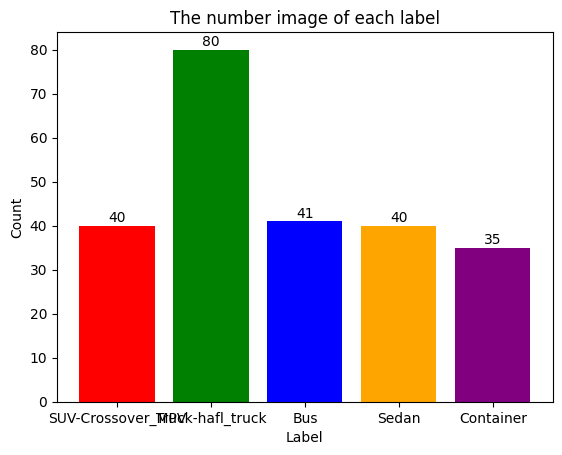

In [ ]:
count=[]
for label in label2idx.keys():
  count.append(df['label'].loc[df['label'] == label].count())

plt.bar(x=label2idx.keys(), height=count, color = ['red', 'green', 'blue', 'orange', 'purple', 'yellow'])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("The number image of each label")

for i, value in enumerate(count):
    plt.text(x=i, y=value + 0.1, s=str(value), ha='center', va='bottom')

plt.show()

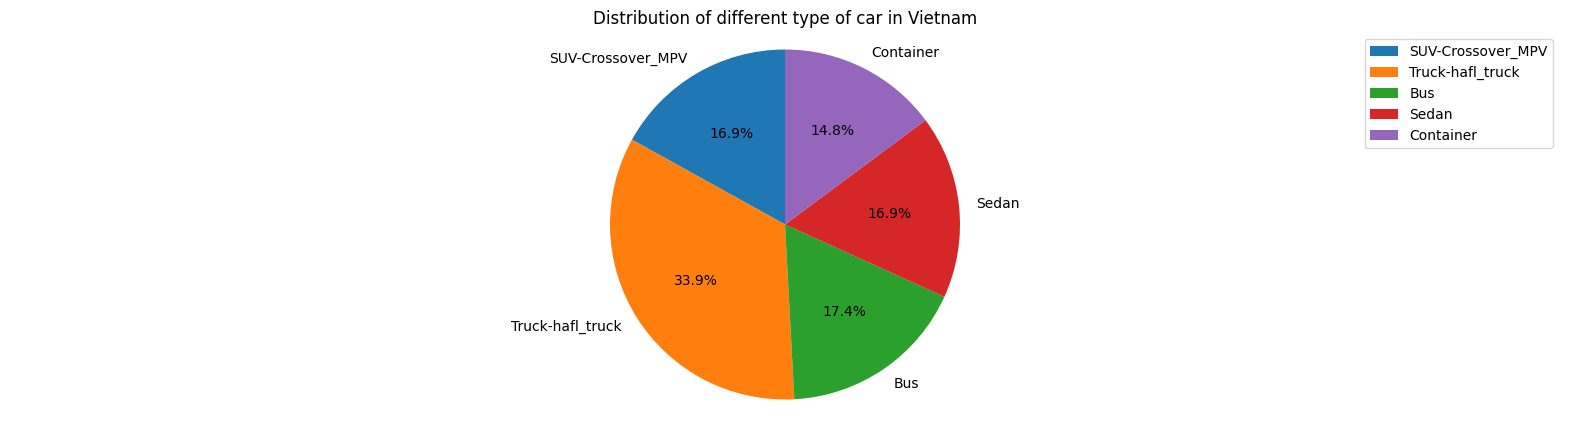

In [ ]:
plt.figure(figsize=(20,5))
plt.pie(x=count, labels=label2idx.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Distribution of different type of car in Vietnam")
plt.axis('equal')
plt.legend()
plt.show()

# Extract features function

In [ ]:
class Feature_Extraction():
  def __init__(self, list_file, list_label, function_name, master_path):
    self.list_path = list_file
    self.list_label = list_label
    self.function_name = function_name
    self.master_path = master_path

  @staticmethod
  def extract_histogram_rgb(img_path, bin = 8):
    img = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color_channel = cv2.split(image_rgb)

    hist_img = [cv2.calcHist([channel],[0], None, [bin], [0,256]) for channel in color_channel]
    hist_img = [cv2.normalize(hist, hist).flatten() for hist in hist_img]

    return np.hstack(hist_img)

  @staticmethod
  def extract_dominant_color(img_path):
    image = cv2.imread(img_path)
    pixels = image.reshape(-1, 3)
    kmeans = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centers = cv2.kmeans(np.float32(pixels), 3, None,
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
    10, kmeans)
    hist = np.bincount(labels.flatten(), minlength=3) / labels.size

    arr = np.hstack([centers.flatten(), hist])
    return arr

  @staticmethod
  def extract_color_moments(img_path):
    image = cv2.imread(img_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    mean = np.mean(hsv, axis=(0, 1))
    std = np.std(hsv, axis=(0, 1))
    skewness = np.mean(((hsv - mean) / (std + 1e-6)) ** 3, axis=(0, 1))

    return np.concatenate([mean, std, skewness])

  @staticmethod
  def extract_lbp(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256,128))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(img_gray, P = 8, R = 1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 8 + 3), range=(0, 8 + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist

  @staticmethod
  def extract_hog(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256,128))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                       block_norm="L2-Hys", feature_vector=True)
    features = hog_features.reshape(1, -1)
    return features[0]

  def forward(self):
    X = []
    y = []

    for label in self.list_label:
      for img in self.list_path[label]:
        img_path = os.path.join(self.master_path, label, img)
        function = getattr(self, self.function_name)
        vector = function(img_path)

        X.append(vector)
        y.append(label2idx[label])

    if self.function_name == 'extract_hog':
      return np.stack(X), np.array(y)
    return np.array(X), np.array(y)

# train test split

In [ ]:
feature_extraction_color_moments = Feature_Extraction(
    list_file=list_file,
    list_label=label2idx.keys(),
    function_name="extract_color_moments",
    master_path=master_path
)

In [ ]:
feature_extraction_color_histogram_rgb = Feature_Extraction(
    list_file=list_file,
    list_label=label2idx.keys(),
    function_name="extract_histogram_rgb",
    master_path=master_path
)

In [ ]:
feature_extraction_dominant_color = Feature_Extraction(
    list_file=list_file,
    list_label=label2idx.keys(),
    function_name="extract_dominant_color",
    master_path=master_path
)

In [ ]:
feature_extraction_hog = Feature_Extraction(
    list_file=list_file,
    list_label=label2idx.keys(),
    function_name="extract_hog",
    master_path=master_path
)

In [ ]:
feature_extraction_lbp = Feature_Extraction(
    list_file=list_file,
    list_label=label2idx.keys(),
    function_name="extract_lbp",
    master_path=master_path
)

In [ ]:
X_hog, y_hog = feature_extraction_hog.forward()

In [ ]:
X_hog.shape

(236, 16740)

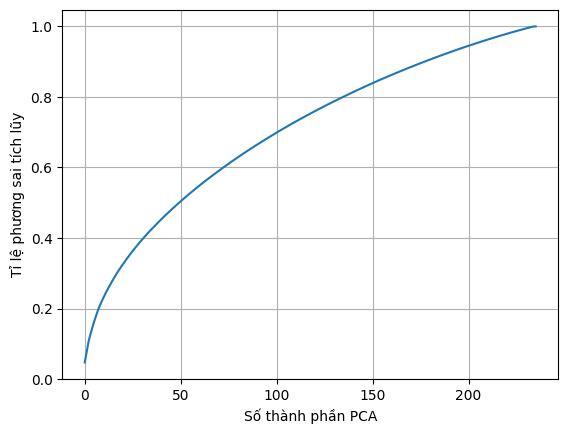

In [ ]:
from sklearn.decomposition import PCA


pca = PCA().fit(X_hog)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Số thành phần PCA')
plt.ylabel('Tỉ lệ phương sai tích lũy')
plt.grid()
plt.show()

In [ ]:
# Áp dụng PCA cho HOG
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
X_hog = pca.fit_transform(X_hog)

In [ ]:
X_lbp, y_lbp = feature_extraction_lbp.forward()

In [ ]:
X_lbp.shape

(236, 10)

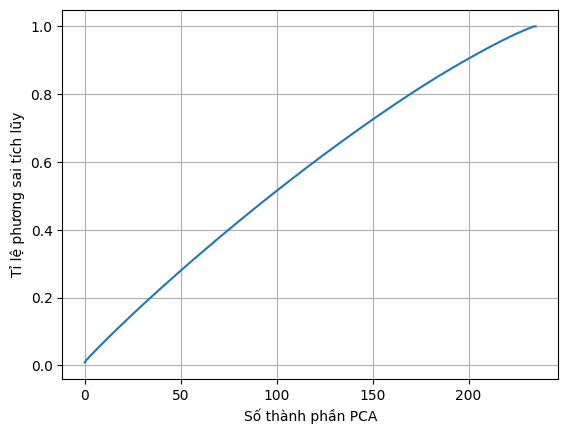

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_lbp)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Số thành phần PCA')
plt.ylabel('Tỉ lệ phương sai tích lũy')
plt.grid()
plt.show()

In [ ]:
X_dominant, y_dominant = feature_extraction_dominant_color.forward()

In [ ]:
X = np.concatenate((X_hog,X_dominant), axis=1)

In [ ]:
X.shape

(236, 40)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_hog, y_hog, random_state=42, test_size=0.2)

print(f"Train: {X_train.shape, y_train.shape}")
print(f"Test: {X_test.shape, y_test.shape}")

Train: ((188, 200), (188,))
Test: ((48, 200), (48,))


# Xây dựng mô hình KNN

In [ ]:
# parameters = {
#     "n_neighbors" : [i + 1 for i in range(1,25) if i % 2 == 0],
#     'weights' : ['uniform', 'distance'],
#     'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
# }

In [ ]:
# from sklearn.model_selection import GridSearchCV

# model = KNeighborsClassifier()
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=parameters,
#     cv=10,
#     scoring='accuracy',
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)

In [ ]:
# grid_search.best_params_

In [ ]:
knn = KNeighborsClassifier(algorithm='auto', n_neighbors=3, weights='distance')
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.33      0.30      0.32        10
           1       1.00      0.87      0.93        15
           2       0.88      0.70      0.78        10
           3       0.40      0.50      0.44         8
           4       0.50      0.80      0.62         5

    accuracy                           0.65        48
   macro avg       0.62      0.63      0.62        48
weighted avg       0.68      0.65      0.66        48



# Xây dựng mô hình SVM

In [ ]:
# parameters = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid' ],
#     'gamma': ['scale', 'auto']
# }

In [ ]:
# model = SVC()
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=parameters,
#     cv=10,
#     scoring='accuracy',
#     n_jobs=-1
# )
# grid_search.fit(X_train, y_train)

In [ ]:
# grid_search.best_params_

In [ ]:
svm = SVC(C=10, gamma='scale', kernel='linear')
svm.fit(X_train,y_train)

y_pred = svm.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         8
           3       0.60      0.67      0.63         9
           4       1.00      1.00      1.00         8

    accuracy                           0.85        48
   macro avg       0.85      0.85      0.85        48
weighted avg       0.86      0.85      0.85        48



In [ ]:
from joblib import dump, load

# Lưu mô hình ra file
dump(svm, 'svm_model.pkl')
dump(pca, 'pca_transformer.pkl')

['pca_transformer.pkl']

In [ ]:
# Tải mô hình từ file
model_loaded = load('/content/svm_model.pkl')
pca_loaded = load('/content/pca_transformer.pkl')

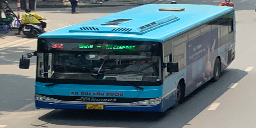

Truck-hafl_truck


In [ ]:
img = cv2.imread('/content/Bus_106.png')

img = cv2.resize(img, (256,128))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hog_features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm="L2-Hys", feature_vector=True)
features = hog_features.reshape(1, -1)

feature = features[0]

feature = pca_loaded.transform(features)
y_pred = model_loaded.predict(feature)

from google.colab.patches import cv2_imshow
cv2_imshow(img)

print(idx2label[y_pred[0]])